<a href="https://colab.research.google.com/github/xdilab/ATC/blob/main/ATC_SIM_v_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/Users/naimbaker/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Current Simulation Time: 000000Z
Updating position for airplane with Hex: a466c7 at time: 000000Z
Updating position for airplane with Hex: a466c7 at time: 000005Z

Airplane 1:
Time: 000000Z
Hex: a466c7
Distance to GSO: 9.146023045
Data Source Type: adsb_icao
Flight Number: DAL2230 
Aircraft Registration: N383DN
Aircraft Type: B738
Altitude Barometric: 28000
Altitude Geometric: 29125.0
Ground Speed: 495.0
Track: 204.34
Barometric Rate: 0.0
Squawk Code: 2661.0
Emergency: none
Category: A3
Latitude: 35.951083
Longitude: -79.988183
NIC Navigation Integrity Category: 8.0
RC Navigation Accuracy Category: 186.0
Seen Position: 0.068
Version: 2.0
NIC Baro: 1.0
NAC P: 10.0
NAC V: 2.0
SIL Source Integrity Level: 3.0
SIL Type: perhour
GVA: 2.0
SDA System Design Assurance: 2.0
Alert: 0.0
SPI: 0.0
MLAT: []
TISB: []
Messages: 16602751
Seen: 0.0
RSSI: -10.9

ATIS Transcription:
Filename: KGSO1-ATIS-Jun-01-2024-0000Z.wav
Start: 00:00:00
End: 00:00:03
Final Start: 00:00:00
Final End: 00:00:03
Transcrip

FileNotFoundError: [Errno 2] No such file or directory: '/Users/naimbaker/Documents/GitHub/ATC/airplane.webp'

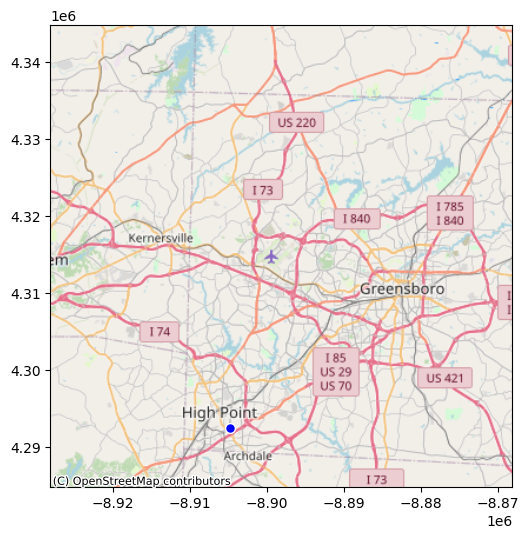

In [ ]:
import pandas as pd
import time as tm
import csv
from datetime import datetime, timedelta, time
import os
from collections import Counter
import math
import json
import re
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import Affine2D
from scipy.ndimage import rotate

# Class Definitions

coord_tracker = {} # Tracks the current aircraft coordinates to calculate direction
direction_tracker = {} # Tracks the current aircraft coordinates to plot direction

class Airplane:
    def __init__(self, data):
        self.time = data.get('Time', '')
        self.hex = data.get('Hex', '')
        self.dist_to_gso = data.get('Distance to GSO', '')
        self.ds_type = data.get('DS Type', '')
        self.flight_number = data.get('Flight #', '')
        self.aircraft_reg = data.get('Aircraft_Reg', '')
        self.aircraft_type = data.get('Aircraft_Type', '')
        self.altitude_baro = data.get('Altitude Baro', '')
        self.altitude_geom = data.get('Altitude Geom', '')
        self.ground_speed = data.get('Ground Speed', '')
        self.track = data.get('Track', '')
        self.baro_rate = data.get('Baro Rate', '')
        self.squawk = data.get('Squawk', '')
        self.emergency = data.get('Emergency', '')
        self.category = data.get('Category', '')
        self.latitude = float(data.get('Latitude', '0'))
        self.longitude = float(data.get('Longitude', '0'))
        self.nic_navigation = data.get('NIC Navigation Integrity Category', '')
        self.rc_navigation = data.get('RC Navigation Accuracy Category', '')
        self.seen_position = data.get('Seen Position', '')
        self.version = data.get('Version', '')
        self.nic_baro = data.get('NIC Baro', '')
        self.nac_p = data.get('NAC P', '')
        self.nac_v = data.get('NAC V', '')
        self.sil_level = data.get('SIL Source Integrity Level ', '')
        self.sil_type = data.get('SIL Type', '')
        self.gva = data.get('GVA', '')
        self.sda = data.get('SDA System Design Assurance', '')
        self.alert = data.get('Alert', '')
        self.spi = data.get('SPI', '')
        self.mlat = data.get('MLAT', '')
        self.tisb = data.get('TISB', '')
        self.messages = data.get('Messages', '')
        self.seen = data.get('Seen', '')
        self.rssi = data.get('RSSI', '')

        # Initialization of airspace status
        self.a_statt = self.determine_airspace_status()

    def determine_airspace_status(self):
        try:
            lat = float(self.latitude) if self.latitude else 0.0
            lon = float(self.longitude) if self.longitude else 0.0
        except ValueError:
            lat = 0.0
            lon = 0.0

        try:
            altitude_geom = float(self.altitude_geom) if self.altitude_geom else 0.0
        except ValueError:
            altitude_geom = 0.0

        try:
            altitude_baro = float(self.altitude_baro) if self.altitude_baro else 0.0
        except ValueError:
            altitude_baro = 0.0

        try:
            ground_speed = float(self.ground_speed) if self.ground_speed else 0.0
        except ValueError:
            ground_speed = 0.0

        # Determine status based on location and altitude
        if 30.0 < lat < 35.0 and -80.0 < lon < -75.0:
            return 'Arriving'
        elif 25.0 < lat < 30.0 and -85.0 < lon < -80.0:
            return 'Departing'
        elif altitude_geom > 10000:
            return 'Passing'
        elif ground_speed > 0 and altitude_geom == 0:
            return 'Taxiing'
        elif self.altitude_baro == 'ground':  # Check if altitude_baro equals the string 'ground'
            return 'Grounded/Parked'
        else:
            return 'Unknown'



    def to_dict(self):
        return {
            "Time": self.time,
            "Hex": self.hex,
            "Distance to GSO": self.dist_to_gso,
            "Airspace Status": self.a_statt,  # Include airspace status in the dict
            "Data Source Type": self.ds_type,
            "Flight Number": self.flight_number,
            "Aircraft Registration": self.aircraft_reg,
            "Aircraft Type": self.aircraft_type,
            "Altitude Barometric": self.altitude_baro,
            "Altitude Geometric": self.altitude_geom,
            "Ground Speed": self.ground_speed,
            "Track": self.track,
            "Barometric Rate": self.baro_rate,
            "Squawk Code": self.squawk,
            "Emergency": self.emergency,
            "Category": self.category,
            "Latitude": self.latitude,
            "Longitude": self.longitude,
            "NIC Navigation Integrity Category": self.nic_navigation,
            "RC Navigation Accuracy Category": self.rc_navigation,
            "Seen Position": self.seen_position,
            "Version": self.version,
            "NIC Baro": self.nic_baro,
            "NAC P": self.nac_p,
            "NAC V": self.nac_v,
            "SIL Source Integrity Level": self.sil_level,
            "SIL Type": self.sil_type,
            "GVA": self.gva,
            "SDA System Design Assurance": self.sda,
            "Alert": self.alert,
            "SPI": self.spi,
            "MLAT": self.mlat,
            "TISB": self.tisb,
            "Messages": self.messages,
            "Seen": self.seen,
            "RSSI": self.rssi
        }

    def update_position(self, current_time, interval_seconds):
        if self.time:
            try:
                airplane_time = datetime.strptime(self.time, '%H%M%SZ')
                time_diff = abs((airplane_time - current_time).total_seconds())
                if time_diff <= interval_seconds:
                    print(f"Updating position for airplane with Hex: {self.hex} at time: {self.time}")
            except ValueError:
                pass

class ATISTranscription:
    def __init__(self, filename, start, end, final_start, final_end, transcription_id, transcription_text):
        self.filename = filename
        self.start = start
        self.end = end
        self.final_start = final_start
        self.final_end = final_end
        self.transcription_id = transcription_id
        self.transcription_text = transcription_text

class ApproachDepartureTranscription:
    def __init__(self, filename, start, end, final_start, final_end, transcription_id, transcription_text):
        self.filename = filename
        self.start = start
        self.end = end
        self.final_start = final_start
        self.final_end = final_end
        self.transcription_id = transcription_id
        self.transcription_text = transcription_text

class TOWERTranscription:
    def __init__(self, filename, start, end, final_start, final_end, transcription_id, transcription_text):
        self.filename = filename
        self.start = start
        self.end = end
        self.final_start = final_start
        self.final_end = final_end
        self.transcription_id = transcription_id
        self.transcription_text = transcription_text

class TranscriptionHandler:
    @staticmethod
    def get_transcriptions(airplane, transcriptions):
        transcription_texts = {
            'ATIS': [],
            'Approach/Departure': [],
            'TOWER': []
        }
        if airplane.time:
            try:
                airplane_time = datetime.strptime(airplane.time, '%H%M%SZ').time()

                # Initialize a dictionary to store the previous transcription ID for each source
                previous_transcription_id = {
                    'ATIS': None,
                    'Approach/Departure': None,
                    'TOWER': None
                }

                for source, trans_list in transcriptions.items():
                    for t in trans_list:
                        # Check if the transcription falls within the time range
                        if t.final_start <= airplane_time <= t.final_end:
                            # If this is the first transcription, or if the ID is sequential, add it
                            if previous_transcription_id[source] is None or t.transcription_id > previous_transcription_id[source]:
                                transcription_texts[source].append(t)
                                # Update the previous transcription ID
                                previous_transcription_id[source] = t.transcription_id

            except ValueError:
                pass

        return transcription_texts


# Utility Functions

def load_transcriptions_from_csv(csv_files):
    transcriptions = {'ATIS': [], 'Approach/Departure': [], 'TOWER': []}
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            for _, row in df.iterrows():

              # POSSIBLY ADD FINAL START AND END TIME ROWS HERE. have transcription time take priority if current final start time is > prev.
                start_time = datetime.strptime(row['Start'], '%H:%M:%S').time()
                end_time = datetime.strptime(row['End'], '%H:%M:%S').time()
                final_start_time = datetime.strptime(row['Final_Start'], '%H:%M:%S').time()
                final_end_time = datetime.strptime(row['Final_End'], '%H:%M:%S').time()
                tran_id = row['Transcription_id']
                if 'ATIS' in row['Filename']:
                    transcriptions['ATIS'].append(ATISTranscription(row['Filename'], start_time, end_time, final_start_time, final_end_time, tran_id, row['Transcription']))
                elif 'App-Dep' in row['Filename']:
                    transcriptions['Approach/Departure'].append(ApproachDepartureTranscription(row['Filename'], start_time, end_time, final_start_time, final_end_time, tran_id, row['Transcription']))
                elif 'Twr' in row['Filename']:
                    transcriptions['TOWER'].append(TOWERTranscription(row['Filename'], start_time, end_time, final_start_time, final_end_time, tran_id, row['Transcription']))
        except FileNotFoundError:
            print(f"File not found: {csv_file}")
    return transcriptions


def load_airplanes_from_csv(csv_file):
    try:
        df = pd.read_csv(csv_file)
        return [Airplane(row) for _, row in df.iterrows()]
    except FileNotFoundError:
        print(f"File not found: {csv_file}")
        return []


def simulate_data_update(airplanes, current_time, interval_seconds):
    for airplane in airplanes:
        airplane.update_position(current_time, interval_seconds)


def convert_filename_to_timedelta(filename_time_str):
    """Convert filename time string (HHMMZ) to timedelta."""
    hours = int(filename_time_str[:2])
    minutes = int(filename_time_str[2:4])
    return timedelta(hours=hours, minutes=minutes)


def add_time_offset(filename_time_delta, transcription_time_str):
    """Add timedelta to transcription time string."""
    transcription_time = datetime.strptime(transcription_time_str, '%H:%M:%S')
    new_time = transcription_time + filename_time_delta
    return new_time.strftime('%H:%M:%S')


def get_traveled_distance(coord1, coord2):
    lat1, long1 = coord1
    lat2, long2 = coord2

    d_lat = lat2 - lat1
    d_long = long2 - long1

    if d_lat > 0 and d_long > 0:
        return "NE"
    elif d_lat > 0 and d_long < 0:
        return "NW"
    elif d_lat < 0 and d_long > 0:
        return "SE"
    elif d_lat < 0 and d_long < 0:
        return "SW"
    elif d_lat > 0:
        return "N"
    elif d_lat < 0:
        return "S"
    elif d_long > 0:
        return "E"
    elif d_long < 0:
        return "W"
    else:
        return None
    

def get_direction(coordinates, flightNumber):
    result = []
    prev = None # Previous coordinate

    if len(coordinates) == 1:
        flight = flightNumber[0]

        if flight['Flight Number'] not in coord_tracker:
            coord_tracker[flight['Flight Number']] = coordinates[0]
        else:
            prev = coord_tracker[flight['Flight Number']]
            coord_tracker[flight['Flight Number']] = coordinates[0]
            return {flight['Flight Number'] : get_traveled_distance(prev, coord_tracker[flight['Flight Number']])}
    
    elif len(coordinates) == 0:
        return
    
    else:
        for i in range(len(coordinates)):
            flight = flightNumber[i]
            
            if flight['Flight Number'] not in coord_tracker:
                coord_tracker[flight['Flight Number']] = coordinates[i]
            else:
                prev = coord_tracker[flight['Flight Number']]
                coord_tracker[flight['Flight Number']] = coordinates[i]
                result.append({flight['Flight Number'] : get_traveled_distance(prev, coord_tracker[flight['Flight Number']])})

        return result
    

def get_status(flightNumber, status):
    statusList = []
    
    if len(status) == 1:
        result = status[0]
        flight = flightNumber[0]

        return {flight['Flight Number'] : result['Airspace Status']}
    elif len(status) > 1:
        for i in range(len(status)):
            result = status[i]
            flight = flightNumber[i]

            statusList.append({flight['Flight Number'] : result['Airspace Status']})

    if len(statusList) >= 1:
        return statusList
    
    return


def status_count(flightNumber, status):
    res = [get_status(flightNumber, status)]
    status_dict = res[0]

    if res[0] == None:
        return

    if len(status_dict) == 1:
        values = status_dict.values()
        count = Counter(values)
        count_dict = dict(count)

        return count_dict

    elif len(status_dict) > 1:
        values = [v for d in status_dict for v in d.values()]
        count = Counter(values)
        count_dict = dict(count)

        return count_dict
    
    return


def convert_direction(direction):

    conversion = None

    if direction == "W":
        conversion = 270
    elif direction == "NW":
        conversion = 315
    if direction == "N":
        conversion = 0
    if direction == "NE":
        conversion = 45
    if direction == "E":
        conversion = 90
    if direction == "SE":
        conversion = 135
    if direction == "S":
        conversion = 180
    if direction == "SW":
        conversion = 255

    return conversion


def plot_coordinates(coordinates, flight_numbers, center, current_flight_time, zoom_factor=30000, basemap_zoom=10):
    direction = []
    prev = None

    gdf = gpd.GeoDataFrame(
        flight_numbers,
        geometry=[Point(coord[1], coord[0]) for coord in coordinates],
        crs="EPSG:4326"
    )

    if len(coordinates) == 1:
        flight = flight_numbers[0]

        if flight['Flight Number'] not in direction_tracker:
            direction_tracker[flight['Flight Number']] = coordinates[0]
        else:
            prev = direction_tracker[flight['Flight Number']]
            direction_tracker[flight['Flight Number']] = coordinates[0]
            direction.append(convert_direction(get_traveled_distance(prev, direction_tracker[flight['Flight Number']])))
        
    else:
        for i in range(len(coordinates)):
            flight = flight_numbers[i]

            if flight['Flight Number'] not in direction_tracker:
                direction_tracker[flight['Flight Number']] = coordinates[i]
            else:
                prev = direction_tracker[flight['Flight Number']]
                direction_tracker[flight['Flight Number']] = coordinates[i]
                direction.append(convert_direction(get_traveled_distance(prev, direction_tracker[flight['Flight Number']])))


    print("Direction is" , direction , "degrees")
    
    # Convert to web mercator
    gdf = gdf.to_crs(epsg=3857)
    
    # Convert center point to web mercator
    center_point = gpd.GeoSeries([Point(center[1], center[0])], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]

    # Set fixed extent around the center point
    xlim = (center_point.x - zoom_factor, center_point.x + zoom_factor)
    ylim = (center_point.y - zoom_factor, center_point.y + zoom_factor)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(ax=ax, color='blue', alpha=1, edgecolor='w', markersize=50)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect("equal")

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=basemap_zoom)

    airplane_icon = mpimg.imread("airplane.webp")

    for i, row in gdf.iterrows():
        angle = direction[i] if i < len(direction) else 0  # Get rotation angle

        if angle is None:
            continue

        # Rotate the airplane image before displaying
        rotated_airplane = rotate(airplane_icon, angle, reshape=True)

        # Create an OffsetImage with the rotated image
        imagebox = OffsetImage(rotated_airplane, zoom=0.05)

        # Create AnnotationBbox
        ab = AnnotationBbox(imagebox, (row.geometry.x, row.geometry.y), frameon=False)
        ax.add_artist(ab)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f"Aircraft Positions(Time:{current_flight_time})")

    for i, row in gdf.iterrows():
        ax.text(row.geometry.x, row.geometry.y + 1000, row['Flight Number'], fontsize=9, ha='center', color='red')

    folder_name = "ATC Aircraft Maps"
    os.makedirs(folder_name, exist_ok=True)

    def get_next_filename(folder, base_name="ATC-plot_", ext=".png"):
        i = 1
        while os.path.exists(os.path.join(folder, f"{base_name}{i}{ext}")):
            i += 1
        return os.path.join(folder, f"{base_name}{i}{ext}")

    file_path = get_next_filename(folder_name)
    plt.savefig(file_path)
    
    ax.set_axis_off()
    plt.grid(True)
    plt.show()
    plt.close()


def write_snapshot_to_csv(airplanes, filename, output_path, transcriptions, interval_seconds, start_time_str, end_time_str):
    print(f"Writing snapshot to {output_path}/{filename}...")
    os.makedirs(output_path, exist_ok=True)

    start_datetime = datetime.strptime(start_time_str, '%H%M%SZ')
    end_datetime = datetime.strptime(end_time_str, '%H%M%SZ')

    time_intervals = [start_datetime + timedelta(seconds=i * interval_seconds) for i in range((end_datetime - start_datetime).seconds // interval_seconds + 1)]
    rows_by_time = {}

    for idx, current_time in enumerate(time_intervals):
        current_time_str = current_time.strftime('%H%M%SZ')
        time_range_start = current_time - timedelta(seconds=interval_seconds)
        time_range_end = current_time

        if current_time_str not in rows_by_time:
            rows_by_time[current_time_str] = {
                'DT Time': current_time_str,
                'Aircraft(Obj)': {},
                'Debug 1': [],
                'Debug 2': [],
                'Debug 3': [],
                'Status Count': [],
                'Airspace Status': [],
                'Traveled_Direction': [],
                'ATIS Transcription Start': [],
                'ATIS Transcription End': [],
                'ATIS Transcription Final_Start': [],
                'ATIS Transcription Final_End': [],
                'ATIS Transcription_id': [],  # Ensure initialization for transcription_id
                'ATIS Transcription Text': [],
                'Approach/Departure Transcription Start': [],
                'Approach/Departure Transcription End': [],
                'Approach/Departure Final_Start': [],
                'Approach/Departure Final_End': [],
                'Approach/Departure Transcription_id': [],  # Ensure initialization for transcription_id
                'Approach/Departure Transcription Text': [],
                'TOWER Transcription Start': [],
                'TOWER Transcription End': [],
                'TOWER Final_Start': [],
                'TOWER Final_End': [],
                'TOWER Transcription_id': [],  # Ensure initialization for transcription_id
                'TOWER Transcription Text': []
            }

        latest_airplanes = {}
        for airplane in airplanes:
            airplane_time = datetime.strptime(airplane.time, '%H%M%SZ')
            if time_range_start <= airplane_time <= time_range_end:
                if airplane.hex not in latest_airplanes or airplane_time > latest_airplanes[airplane.hex]['time']:
                    latest_airplanes[airplane.hex] = {'time': airplane_time, 'data': airplane}

        rows_by_time[current_time_str]['Aircraft(Obj)'] = [airplane['data'].to_dict() for airplane in latest_airplanes.values()]

        previous_time = time_intervals[idx - 1] if idx > 0 else start_datetime
        transcriptions_for_time = {source: [] for source in ['ATIS', 'Approach/Departure', 'TOWER']}

        for source, trans_list in transcriptions.items():
            transcriptions_for_time[source] = [t for t in trans_list if previous_time.time() <= t.final_start <= current_time.time()]

        for source in transcriptions_for_time:
            for trans in transcriptions_for_time[source]:
                transcription_filename_time_str = trans.filename.split('-')[-1].replace('.wav', '')
                transcription_filename_time_delta = convert_filename_to_timedelta(transcription_filename_time_str)

                transcription_start_time = trans.start.strftime('%H:%M:%S')
                transcription_end_time = trans.end.strftime('%H:%M:%S')

                final_start_time = add_time_offset(transcription_filename_time_delta, transcription_start_time)
                final_end_time = add_time_offset(transcription_filename_time_delta, transcription_end_time)

                if source == 'ATIS':
                    rows_by_time[current_time_str]['ATIS Transcription Start'].append(trans.start.strftime('%H:%M:%S'))
                    rows_by_time[current_time_str]['ATIS Transcription End'].append(trans.end.strftime('%H:%M:%S'))
                    rows_by_time[current_time_str]['ATIS Transcription Final_Start'].append(final_start_time)
                    rows_by_time[current_time_str]['ATIS Transcription Final_End'].append(final_end_time)
                    rows_by_time[current_time_str]['ATIS Transcription_id'].append(str(trans.transcription_id))
                    rows_by_time[current_time_str]['ATIS Transcription Text'].append(f'"{trans.transcription_text}"')

                elif source == 'Approach/Departure':
                    rows_by_time[current_time_str]['Approach/Departure Transcription Start'].append(trans.start.strftime('%H:%M:%S'))
                    rows_by_time[current_time_str]['Approach/Departure Transcription End'].append(trans.end.strftime('%H:%M:%S'))
                    rows_by_time[current_time_str]['Approach/Departure Final_Start'].append(final_start_time)
                    rows_by_time[current_time_str]['Approach/Departure Final_End'].append(final_end_time)
                    rows_by_time[current_time_str]['Approach/Departure Transcription_id'].append(str(trans.transcription_id))
                    rows_by_time[current_time_str]['Approach/Departure Transcription Text'].append(f'"{trans.transcription_text}"')

                elif source == 'TOWER':
                    rows_by_time[current_time_str]['TOWER Transcription Start'].append(trans.start.strftime('%H:%M:%S'))
                    rows_by_time[current_time_str]['TOWER Transcription End'].append(trans.end.strftime('%H:%M:%S'))
                    rows_by_time[current_time_str]['TOWER Final_Start'].append(final_start_time)
                    rows_by_time[current_time_str]['TOWER Final_End'].append(final_end_time)
                    rows_by_time[current_time_str]['TOWER Transcription_id'].append(str(trans.transcription_id))
                    rows_by_time[current_time_str]['TOWER Transcription Text'].append(f'"{trans.transcription_text}"')

    with open(os.path.join(output_path, filename), 'w', newline='') as file:
        writer = csv.writer(file, quotechar='"', quoting=csv.QUOTE_MINIMAL)
        headers = [
            'DT Time', 'Aircraft(Obj)', 'debug 1', 'debug 2', 'debug 3', 'Status Count', 'Airspace Status', 'Traveled_Direction', 'ATIS Transcription Start', 'ATIS Transcription End',
            'ATIS Transcription Final_Start', 'ATIS Transcription Final_End', 'ATIS Transcription_id', 'ATIS Transcription Text',
            'Approach/Departure Transcription Start', 'Approach/Departure Transcription End',
            'Approach/Departure Final_Start', 'Approach/Departure Final_End', 'Approach/Departure Transcription_id', 'Approach/Departure Transcription Text',
            'TOWER Transcription Start', 'TOWER Transcription End', 'TOWER Final_Start', 'TOWER Final_End',
            'TOWER Transcription_id', 'TOWER Transcription Text'
        ]
        writer.writerow(headers)

        previous_transcriptions = {
            'Aircraft(Obj)': '[]', 'debug 1': 'None', 'debug 2': 'None', 'debug 3': 'None', 'Status Count': 'None', 'Airspace Status': 'None', 'Traveled_Direction': 'None', 'ATIS Transcription Start': 'None', 'ATIS Transcription End': 'None',
            'ATIS Transcription Final_Start': 'None', 'ATIS Transcription Final_End': 'None', 'ATIS Transcription_id': 'None', 'ATIS Transcription Text': 'None',
            'Approach/Departure Transcription Start': 'None', 'Approach/Departure Transcription End': 'None',
            'Approach/Departure Final_Start': 'None', 'Approach/Departure Final_End': 'None', 'Approach/Departure Transcription_id': 'None',
            'Approach/Departure Transcription Text': 'None', 'TOWER Transcription Start': 'None', 'TOWER Transcription End': 'None',
            'TOWER Final_Start': 'None', 'TOWER Final_End': 'None', 'TOWER Transcription_id': 'None', 'TOWER Transcription Text': 'None'
        }

        for i, time_key in enumerate(sorted(rows_by_time.keys())):
            data = rows_by_time[time_key]

            if i == 0:
                row = [
                    data['DT Time'], previous_transcriptions['Aircraft(Obj)'],
                    previous_transcriptions['ATIS Transcription Start'], previous_transcriptions['ATIS Transcription End'],
                    previous_transcriptions['ATIS Transcription Final_Start'], previous_transcriptions['ATIS Transcription Final_End'],
                    previous_transcriptions['ATIS Transcription_id'],
                    previous_transcriptions['ATIS Transcription Text'],
                    previous_transcriptions['Approach/Departure Transcription Start'], previous_transcriptions['Approach/Departure Transcription End'],
                    previous_transcriptions['Approach/Departure Final_Start'], previous_transcriptions['Approach/Departure Final_End'],
                    previous_transcriptions['Approach/Departure Transcription_id'],
                    previous_transcriptions['Approach/Departure Transcription Text'],
                    previous_transcriptions['TOWER Transcription Start'], previous_transcriptions['TOWER Transcription End'],
                    previous_transcriptions['TOWER Final_Start'], previous_transcriptions['TOWER Final_End'],
                    previous_transcriptions['TOWER Transcription_id'],
                    previous_transcriptions['TOWER Transcription Text']
                ]
            else:
                coordinates = [[entry['Latitude'], entry['Longitude']] for entry in data['Aircraft(Obj)'] if 'Latitude' in entry and 'Longitude' in entry]
                flight_numbers = [{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']]
                # directions = get_direction([[entry['Latitude'], entry['Longitude']] for entry in data['Aircraft(Obj)'] if 'Latitude' in entry and 'Longitude' in entry], [{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']])
                current_flight_time = data['DT Time']
                center_point = (36.1029, -79.9335)  # Greensboro Airport

                # Updated row creation logic
                row = [
                    data['DT Time'],
                    str(data['Aircraft(Obj)']),
                    str([{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']]),
                    len([{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']]),
                    str([{key: entry[key] for key in ['Distance to GSO', 'Flight Number', 'Aircraft Registration'] if key in entry} for entry in data['Aircraft(Obj)']]),
                    status_count([{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']], [{key: entry[key] for key in ['Airspace Status'] if key in entry} for entry in data['Aircraft(Obj)']]),
                    get_status([{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']], [{key: entry[key] for key in ['Airspace Status'] if key in entry} for entry in data['Aircraft(Obj)']]),
                    get_direction([[entry['Latitude'], entry['Longitude']] for entry in data['Aircraft(Obj)'] if 'Latitude' in entry and 'Longitude' in entry], [{key: entry[key] for key in ['Flight Number'] if key in entry} for entry in data['Aircraft(Obj)']]),
                    ', '.join(data['ATIS Transcription Start']) if data['ATIS Transcription Start'] else 'None',
                    ', '.join(data['ATIS Transcription End']) if data['ATIS Transcription End'] else 'None',
                    ', '.join(data['ATIS Transcription Final_Start']) if data['ATIS Transcription Final_Start'] else 'None',
                    ', '.join(data['ATIS Transcription Final_End']) if data['ATIS Transcription Final_End'] else 'None',
                    ', '.join(map(str, data['ATIS Transcription_id'])) if data['ATIS Transcription_id'] else 'None',
                    ' | '.join(data['ATIS Transcription Text']) if data['ATIS Transcription Text'] else 'None',
                    ', '.join(data['Approach/Departure Transcription Start']) if data['Approach/Departure Transcription Start'] else 'None',
                    ', '.join(data['Approach/Departure Transcription End']) if data['Approach/Departure Transcription End'] else 'None',
                    ', '.join(data['Approach/Departure Final_Start']) if data['Approach/Departure Final_Start'] else 'None',
                    ', '.join(data['Approach/Departure Final_End']) if data['Approach/Departure Final_End'] else 'None',
                    ', '.join(map(str, data['Approach/Departure Transcription_id'])) if data['Approach/Departure Transcription_id'] else 'None',
                    ' | '.join(data['Approach/Departure Transcription Text']) if data['Approach/Departure Transcription Text'] else 'None',
                    ', '.join(data['TOWER Transcription Start']) if data['TOWER Transcription Start'] else 'None',
                    ', '.join(data['TOWER Transcription End']) if data['TOWER Transcription End'] else 'None',
                    ', '.join(data['TOWER Final_Start']) if data['TOWER Final_Start'] else 'None',
                    ', '.join(data['TOWER Final_End']) if data['TOWER Final_End'] else 'None',
                    ', '.join(map(str, data['TOWER Transcription_id'])) if data['TOWER Transcription_id'] else 'None',
                    ' | '.join(data['TOWER Transcription Text']) if data['TOWER Transcription Text'] else 'None',
                    plot_coordinates(coordinates, flight_numbers, center_point, current_flight_time)
                ]


            previous_transcriptions.update(data)
            writer.writerow(row)


# Main Execution

def main():
    transcription_files = [
        '/Users/naimbaker/Documents/ATC/new_freq_filesWAV2TXT - KGSO_ATIS 2_reformatted_with_final_times_VID.csv',
        '/Users/naimbaker/Documents/ATC/new_freq_filesWAV2TXT - KGSO_Approach_Departure 2_reformatted_with_final_times_VID.csv',
        '/Users/naimbaker/Documents/ATC/new_freq_filesWAV2TXT - KGSO_TOWER 2_reformatted_with_final_times_VID.csv'
    ]

    # Load transcriptions
    transcriptions = load_transcriptions_from_csv(transcription_files)

    csv_file = '/Users/naimbaker/Documents/ATC/adsb_hist_06_01_24_cleaned (4).csv'
    # Load airplanes
    airplanes = load_airplanes_from_csv(csv_file)

    start_time_str = input("Enter start time (e.g., 000000Z): ").strip()
    end_time_str = input("Enter end time (e.g., 010000Z): ").strip()
    interval_str = input("Enter time interval (e.g., 30s, 1m): ").strip()
    speed_str = input("Enter execution speed (e.g., 1.0 for normal speed): ").strip()

    try:
        start_time = datetime.strptime(start_time_str, '%H%M%SZ')
        end_time = datetime.strptime(end_time_str, '%H%M%SZ')
        interval = int(interval_str[:-1])
        if interval_str[-1] == 'm':
            interval *= 60
        elif interval_str[-1] == 's':
            pass
        else:
            raise ValueError("Interval should be in 's' or 'm'.")
        speed = float(speed_str)
        interval_seconds = interval

        time_points = [start_time + timedelta(seconds=i * interval) for i in range((end_time - start_time).seconds // interval + 1)]

        output_path = '/Users/naimbaker/Documents/ATC'
        all_filtered_airplanes = []

        for current_time in time_points:
            print(f"\nCurrent Simulation Time: {current_time.strftime('%H%M%SZ')}")
            filtered_airplanes = [
                airplane for airplane in airplanes
                if abs((datetime.strptime(airplane.time, '%H%M%SZ') - current_time).total_seconds()) <= interval_seconds
            ]

            simulate_data_update(filtered_airplanes, current_time, interval_seconds)
            all_filtered_airplanes.extend(filtered_airplanes)  # Collect data

            # Optional: print details of airplanes for current time
            for idx, airplane in enumerate(filtered_airplanes, 1):
                print(f"\nAirplane {idx}:")
                print(f"Time: {airplane.time}")
                print(f"Hex: {airplane.hex}")
                print(f"Distance to GSO: {airplane.dist_to_gso}")
                print(f"Data Source Type: {airplane.ds_type}")
                print(f"Flight Number: {airplane.flight_number}")
                print(f"Aircraft Registration: {airplane.aircraft_reg}")
                print(f"Aircraft Type: {airplane.aircraft_type}")
                print(f"Altitude Barometric: {airplane.altitude_baro}")
                print(f"Altitude Geometric: {airplane.altitude_geom}")
                print(f"Ground Speed: {airplane.ground_speed}")
                print(f"Track: {airplane.track}")
                print(f"Barometric Rate: {airplane.baro_rate}")
                print(f"Squawk Code: {airplane.squawk}")
                print(f"Emergency: {airplane.emergency}")
                print(f"Category: {airplane.category}")
                print(f"Latitude: {airplane.latitude}")
                print(f"Longitude: {airplane.longitude}")
                print(f"NIC Navigation Integrity Category: {airplane.nic_navigation}")
                print(f"RC Navigation Accuracy Category: {airplane.rc_navigation}")
                print(f"Seen Position: {airplane.seen_position}")
                print(f"Version: {airplane.version}")
                print(f"NIC Baro: {airplane.nic_baro}")
                print(f"NAC P: {airplane.nac_p}")
                print(f"NAC V: {airplane.nac_v}")
                print(f"SIL Source Integrity Level: {airplane.sil_level}")
                print(f"SIL Type: {airplane.sil_type}")
                print(f"GVA: {airplane.gva}")
                print(f"SDA System Design Assurance: {airplane.sda}")
                print(f"Alert: {airplane.alert}")
                print(f"SPI: {airplane.spi}")
                print(f"MLAT: {airplane.mlat}")
                print(f"TISB: {airplane.tisb}")
                print(f"Messages: {airplane.messages}")
                print(f"Seen: {airplane.seen}")
                print(f"RSSI: {airplane.rssi}")

                transcriptions_for_airplane = TranscriptionHandler.get_transcriptions(airplane, transcriptions)
                for source, texts in transcriptions_for_airplane.items():
                    for trans in texts:
                        print(f"\n{source} Transcription:")
                        print(f"Filename: {trans.filename}")
                        print(f"Start: {trans.start}")
                        print(f"End: {trans.end}")
                        print(f"Final Start: {trans.final_start}")
                        print(f"Final End: {trans.final_end}")
                        print(f"Transcription ID: {trans.transcription_id}")
                        print(f"Transcription: {trans.transcription_text}")

            tm.sleep(interval_seconds / speed)

        # Save the final snapshot after the simulation
        snapshot_file = 'snapshot_final.csv'
        write_snapshot_to_csv(all_filtered_airplanes, snapshot_file, output_path, transcriptions, interval_seconds, start_time_str, end_time_str)
        print(f"Final snapshot saved to {output_path}/{snapshot_file}")

    except ValueError as e:
        print(f"Error in input data: {e}")

    print("Simulation completed.")

if __name__ == "__main__":
    main()
